In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [84]:
TRAIN_DIR = '/Users/jiepeng/Documents/Data_Science/project_example/BBBC005_v1_images'
#TEST_DIR = ''
IMG_SIZE = 50
#LR = 1e-3

MODEL_NAME = 'cell_counter_{}.model'.format('2convfirst')

In [3]:
def label_img(img):
    return int(img.split('_')[-4][1:])

In [14]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        if img == '.DS_Store': pass
        else:
            label = int(img.split('_')[-4][1:])
            path = os.path.join(TRAIN_DIR,img)
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            training_data.append([np.array(img), [label]])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        if img == '.DS_Store': pass
        else:     
            path = os.path.join(TEST_DIR, img)
            img_num = img.split("_")[0]
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
            testing_data.append([np.array(img), img_num])
    np.save('test_data.npy', testing_data)
    return testing_data

In [15]:
train_data = create_train_data()

#train_data = np.load('train_data.npy')

100%|██████████| 19201/19201 [00:28<00:00, 673.26it/s]


In [7]:
train_data[0]

[array([[  1,   1,   1, ...,  91,  55,   5],
        [  1,   1,   3, ..., 110,  46,   3],
        [  1,   1,   7, ...,  62,  18,   7],
        ..., 
        [ 84, 114,  70, ..., 133,  81,   7],
        [ 48,  95,  50, ...,  60,  27,   2],
        [ 15,  39,  17, ...,  10,   2,   1]], dtype=uint8), 91]

In [ ]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [16]:
train = train_data[:-1000]
test = train_data[-1000:]

In [17]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [19]:
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt

In [20]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=X.shape[1:], kernel_initializer='glorot_uniform'))
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_uniform'))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.5))

model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 64)          0         
__________

total epochs is 10

In [70]:
model.fit(X, np.array(Y), epochs=5, batch_size=1000)

Epoch 1/5
18200/18200 [==============================] - 186s 10ms/step - loss: 152.7611 - mean_absolute_percentage_error: 24.6668
Epoch 2/5
18200/18200 [==============================] - 186s 10ms/step - loss: 126.6346 - mean_absolute_percentage_error: 23.3256
Epoch 3/5
18200/18200 [==============================] - 185s 10ms/step - loss: 109.5636 - mean_absolute_percentage_error: 23.2876
Epoch 4/5
18200/18200 [==============================] - 186s 10ms/step - loss: 105.4636 - mean_absolute_percentage_error: 23.3509
Epoch 5/5
18200/18200 [==============================] - 185s 10ms/step - loss: 102.1444 - mean_absolute_percentage_error: 22.5067


In [71]:
score = model.evaluate(test_x, np.array(test_y), verbose=0)
score

[118.48043243408203, 18.960427490234373]

In [72]:
test_pred = model.predict(test_x)

In [73]:
import pandas as pd
prediction = pd.concat([pd.DataFrame(test_pred), pd.DataFrame(test_y)], axis=1)

In [74]:
prediction.columns = ['Prediction', 'Actual']

In [75]:
prediction['error'] = prediction.Actual - prediction.Prediction 
prediction.head()

,Prediction,Actual,error
0,56.798492,61,4.201508
1,90.062752,87,-3.062752
2,77.232780,87,9.767220
3,1.358926,1,-0.358926
4,24.145451,27,2.854549


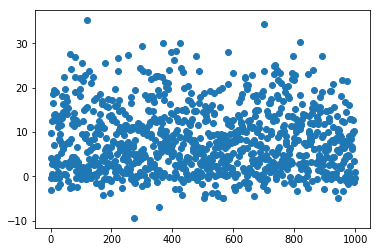

In [76]:
plt.scatter(prediction.index, prediction['error'])
plt.show()

In [77]:
prediction['variance'] = prediction['Actual'] - prediction.Actual.mean()

In [78]:
prediction['error_2'] = prediction['error']**2
prediction['variance_2'] = prediction['variance']**2

In [83]:
prediction

,Prediction,Actual,error,variance,error_2,variance_2
0,56.798492,61,4.201508,9.07,17.652666,82.2649
1,90.062752,87,-3.062752,35.07,9.380448,1229.9049
2,77.232780,87,9.767220,35.07,95.398578,1229.9049
3,1.358926,1,-0.358926,-50.93,0.128828,2593.8649
4,24.145451,27,2.854549,-24.93,8.148452,621.5049
5,57.505058,70,12.494942,18.07,156.123568,326.5249
6,26.456228,27,0.543772,-24.93,0.295688,621.5049
7,6.625711,10,3.374289,-41.93,11.385823,1758.1249
8,55.351826,74,18.648174,22.07,347.754404,487.0849
9,57.431305,74,16.568695,22.07,274.521656,487.0849


In [80]:
r_squared = 1 - prediction.error_2.sum()/prediction.variance_2.sum()

In [81]:
r_squared

0.8704119390834539

In [85]:
model.save(MODEL_NAME)